# **Resolución de la ecuación del calor unidimensional aplicada a una barra de largo L y grosor infinitesimal**

## **Importación de librerías y preparación de entorno**

In [2]:
%env DDE_BACKEND=tensorflow.compat.v1
# %env DDE_BACKEND = tensorflow

env: DDE_BACKEND=tensorflow.compat.v1


In [3]:
import numpy as np
import deepxde as dde
from deepxde.backend import tf
from modulePINN import Geometry, IC_BC, loadData, PINN, Ploter, Makegrid

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


## **Definición de parámetros geométricos del problema**

In [4]:
params_barra = [0, 1, 0, 1] # (t_min, t_max, L_0, L)
barra = Geometry() # Creamos el objeto geométrico: barra
# Creamos el dominio espacio-temporal de la barra
geom_barra, timedomain_barra, geomtime_barra = barra.geometry_domain(params_barra)

In [5]:
icbc = IC_BC(geomtime_barra) # construimos el objeto de condicones iniciales de la barra
ic_barra, bc_barra = icbc.problem_conditions(0.2,   f = lambda x: np.sin(1 * np.pi * x[:, 0:1] / 1)) # Establecemos las condiciones iniciales en la barra

## **Datos sintéticos y entrenamiento**

In [6]:
# Definimos la EDP unidimensional

def pde1d(x, u):
  a = 0.3

  du_t = dde.grad.jacobian(u, x, i=0, j=1) # Obtenemos el jacobiano de u (1ras derivadas) respecto al tiempo (du/dt)
  du_xx = dde.grad.hessian(u, x, i=0, j=0) # Obtenemos el hessiano de u (2das derivadas) respecto a la derivada espacial (d^2/dx^2)u

  eq = du_t - a * du_xx # Definimos la ecuación del calor

  return eq # Retornamos la EDP

In [7]:
# Construimos los datos sintéticos de puntos de colocación en el dominio geométrico

#ndom=2540, nbound=180, ninit=260, ntest=2540

data_barra = loadData(pde1d, geomtime_barra, ic_barra, bc_barra).get_data(2550, 180, 260, 2550)

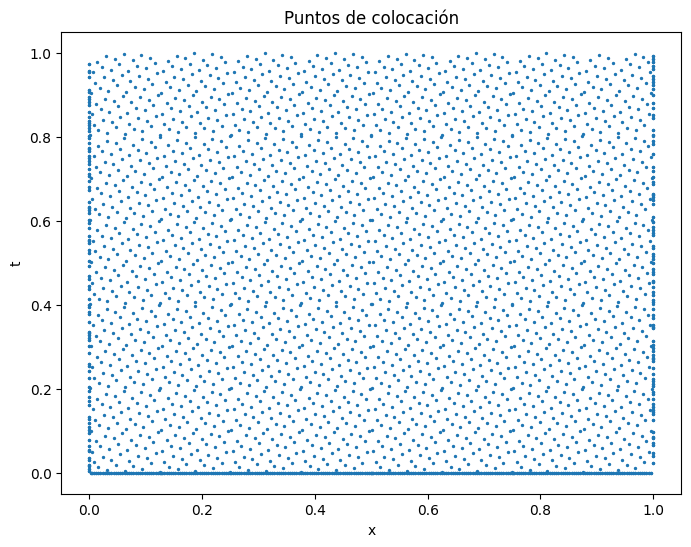

In [8]:
plots = Ploter((8,6)) # Construimos el objeto graficador para la barra
plots.collocation(data_barra) # Graficamos los puntos de colocación (train)

### **Entrenamiento**

In [ ]:
#n_input=2, n_hidden=30, n_output=1, activation="tanh", mmm = "Glorot normal"

pinn_barra = PINN(n_input=2, n_hidden=30, n_output=1, activation="tanh", mmm = "Glorot normal") #Construimos la NN que resolverá la ecuación del calor aplicada a la barra
model, losshistory, train_state = pinn_barra.train_model(data_barra, steps=2000) # Entrenamiento

Compiling model...
Building feed-forward neural network...
'build' took 0.120033 s


'compile' took 0.953048 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.71e-01, 1.46e-01, 9.41e-01]    [1.77e-01, 1.46e-01, 9.41e-01]    []  
1000      [1.83e-03, 8.93e-04, 2.32e-03]    [9.42e-04, 8.93e-04, 2.32e-03]    []  
2000      [3.13e-04, 8.38e-04, 6.16e-04]    [1.67e-04, 8.38e-04, 6.16e-04]    []  
3000      [9.05e-05, 7.11e-04, 4.51e-04]    [5.39e-05, 7.11e-04, 4.51e-04]    []  
4000      [6.57e-05, 6.15e-04, 4.61e-04]    [4.37e-05, 6.15e-04, 4.61e-04]    []  
5000      [4.58e-05, 5.66e-04, 4.75e-04]    [3.02e-05, 5.66e-04, 4.75e-04]    []  
6000      [3.56e-05, 5.36e-04, 4.85e-04]    [2.32e-05, 5.36e-04, 4.85e-04]    []  
7000      [2.86e-05, 5.16e-04, 4.88e-04]    [1.84e-05, 5.16e-04, 4.88e-04]    []  
8000      [2.40e-05, 5.06e-04, 4.83e-04]    [1.54e-05, 5.06e-04, 4.83e-04]    []  
9000      [2.15e-05, 4.92e-04, 4

## **Visualización de resultados**

Saving loss history to c:\Users\sebas\PINNs_UdeA\loss.dat ...
Saving training data to c:\Users\sebas\PINNs_UdeA\train.dat ...
Saving test data to c:\Users\sebas\PINNs_UdeA\test.dat ...


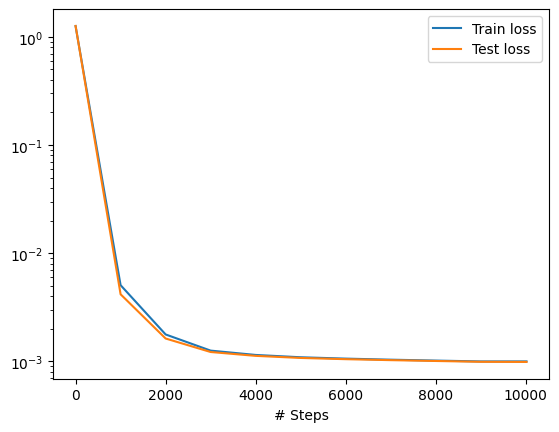

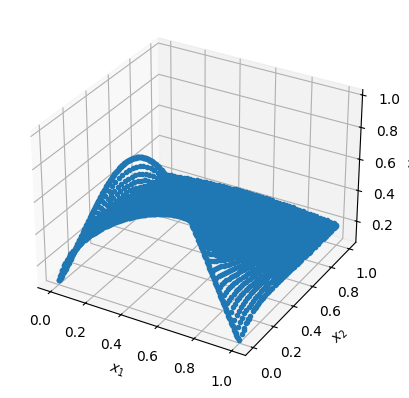

In [10]:
# Observamos la convergencia del modelo y los resultados

plots.train_plot(losshistory, train_state)

In [11]:
n=100
grid = Makegrid()
grid_terms_barra = grid.grid_2D(n, params_barra, model)

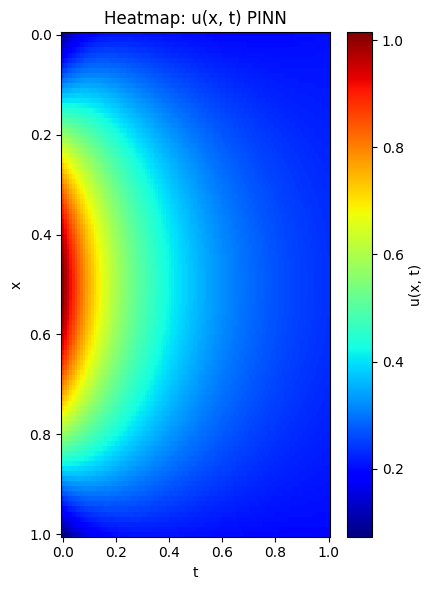

In [12]:
plots.heatmap_plot(grid_terms_barra)

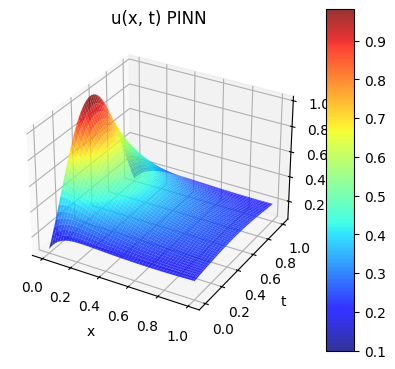

In [13]:
plots.surface_plot(grid_terms_barra)

In [14]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

L=1

# --- Datos de ejemplo (reemplaza con tu U_pred real) ---
# L = 1.0
Nx = 100
Nt = 100
x = np.linspace(0, L, Nx)
t = np.linspace(0, 1, Nt)

# U_pred debe tener forma (Nt, Nx)

X, T = np.meshgrid(x, t)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
XT = np.hstack((X_flat, T_flat))
u_pred_flat = model.predict(XT)
U_pred = u_pred_flat.reshape(100, 100)

# --- Colormap y normalización ---
norm = Normalize(vmin=U_pred.min(), vmax=U_pred.max())
cmap = plt.cm.jet

# --- Figura y ejes ---
fig, ax = plt.subplots(figsize=(8, 2.5))

# Eje principal: solo para eje x
ax.set_xlim(0, L)
ax.set_xlabel("Posición en la barra (x)")
ax.set_yticks([])  # ocultamos ticks de y
ax.set_title("Difusión del calor en la barra, t = 0.00")

# Creamos un eje inset, muy delgado, centrado verticalmente
# width="95%" del ancho del eje principal, height="15%" de su alto
cax = inset_axes(
    ax,
    width="100%",
    height="5%",
    loc="center",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cax.set_xticks([])
cax.set_yticks([])

# Dibujamos la primera fila como heatmap muy delgado
im = cax.imshow(
    U_pred[0:1, :],
    cmap=cmap,
    norm=norm,
    aspect="auto",
    extent=[0, L, 0, 1],  # y va de 0 a 1 dentro del inset (se ve como franja finísima)
)

# Añadimos la colorbar fuera del inset, ligada al principal
cbar = fig.colorbar(im, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("u(x, t)")

# --- Funciones de animación ---
def init():
    im.set_data(U_pred[0:1, :])
    ax.set_title(f"t = {t[0]:.2f}")
    return [im]

def animate(i):
    im.set_data(U_pred[i:i+1, :])
    ax.set_title(f"t = {t[i]:.2f}")
    return [im]

anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=Nt,
    interval=100,
    blit=True,
)

# Mostrar en Jupyter Notebook
from IPython.display import HTML
plt.close(fig)
HTML(anim.to_jshtml())